In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict

# Monte Carlo Simulation
def simulate():
   np.random.seed(42)
   stages = {
       'Pre-Seed': {'median': 3600000, 'sigma': 1.37},
       'Seed': {'median': 9300000, 'sigma': 1.41},
       'Series A': {'median': 45500000, 'sigma': 1.13},
       'Series B': {'median': 115000000, 'sigma': 0.94},
       'Series C': {'median': 345000000, 'sigma': 0.93}
   }
   
   results = []
   transitions = [('Pre-Seed', 'Seed'), ('Seed', 'Series A'), ('Series A', 'Series B'), ('Series B', 'Series C')]
   
   for curr, next_stage in transitions:
       curr_vals = np.random.lognormal(np.log(stages[curr]['median']), stages[curr]['sigma'], 100000)
       next_vals = np.random.lognormal(np.log(stages[next_stage]['median']), stages[next_stage]['sigma'], 100000)
       multiples = next_vals / curr_vals
       
       results.append({
           'transition': f'{curr} → {next_stage}',
           'source': 'Simulation',
           'down_round': (multiples < 1).mean() * 100,
           'below_2x': (multiples < 2).mean() * 100,
           'below_3x': (multiples < 3).mean() * 100,
           'median': np.median(multiples),
           'mean': np.mean(multiples)
       })
   return results

# Real Data Analysis
def analyze_real_data():
   df = pd.read_csv('Valuation Rounds.csv', encoding='cp1252')
   
   stage_map = {'Pre-SEED': 'Pre-Seed', 'SEED': 'Seed', 'Series A': 'Series A', 'Series B': 'Series B', 'Series C': 'Series C'}
   
   clean = df[
       df['Name'].notna() & 
       df['Funding Stage'].isin(stage_map.keys()) &
       (df['Valuation (Estimated)'] > 0)
   ].copy()
   
   clean['stage'] = clean['Funding Stage'].map(stage_map)
   clean['company'] = clean['Name'].str.strip()
   
   companies = defaultdict(list)
   for _, row in clean.iterrows():
       companies[row['company']].append({'stage': row['stage'], 'val': row['Valuation (Estimated)']})
   
   stage_order = {'Pre-Seed': 0, 'Seed': 1, 'Series A': 2, 'Series B': 3, 'Series C': 4}
   transitions = []
   
   for company, rounds in companies.items():
       if len(rounds) < 2: continue
       
       unique = {}
       for r in rounds:
           if r['stage'] not in unique or unique[r['stage']]['val'] < r['val']:
               unique[r['stage']] = r
       
       sorted_rounds = sorted(unique.values(), key=lambda x: stage_order[x['stage']])
       
       for i in range(len(sorted_rounds) - 1):
           curr, next_r = sorted_rounds[i], sorted_rounds[i + 1]
           trans = f"{curr['stage']} → {next_r['stage']}"
           if trans in ['Pre-Seed → Seed', 'Seed → Series A', 'Series A → Series B', 'Series B → Series C']:
               transitions.append({
                   'company': company,
                   'transition': trans, 
                   'from_stage': curr['stage'],
                   'to_stage': next_r['stage'],
                   'from_valuation': curr['val'],
                   'to_valuation': next_r['val'],
                   'multiple': next_r['val'] / curr['val']
               })
   
   # Save transitions to CSV
   transitions_df = pd.DataFrame(transitions)
   transitions_df.to_csv('company_transitions.csv', index=False)
   print(f"💾 Saved {len(transitions)} transitions to 'company_transitions.csv'")
   
   results = []
   for trans_type in ['Pre-Seed → Seed', 'Seed → Series A', 'Series A → Series B', 'Series B → Series C']:
       data = [t['multiple'] for t in transitions if t['transition'] == trans_type]
       if not data: continue
       
       multiples = np.array(data)
       results.append({
           'transition': trans_type,
           'source': 'Real Data',
           'down_round': (multiples < 1).mean() * 100,
           'below_2x': (multiples < 2).mean() * 100,
           'below_3x': (multiples < 3).mean() * 100,
           'median': np.median(multiples),
           'mean': np.mean(multiples)
       })
   
   return results, transitions_df

# Run Analysis
sim_results = simulate()
real_results, transitions_df = analyze_real_data()

# Display Results
all_results = pd.DataFrame(sim_results + real_results)
print("COMPARISON RESULTS:")
for transition in all_results['transition'].unique():
   print(f"\n{transition}:")
   subset = all_results[all_results['transition'] == transition]
   for _, row in subset.iterrows():
       print(f"  {row['source']:<12} | Down:{row['down_round']:5.1f}% | <2x:{row['below_2x']:5.1f}% | <3x:{row['below_3x']:5.1f}% | Med:{row['median']:5.2f}x | Mean:{row['mean']:5.2f}x")

print(f"\nProcessed {len([r for r in real_results])} real transitions vs simulation")

# Save comparison results
all_results.to_csv('comparison_results.csv', index=False)
print("💾 Saved comparison to 'comparison_results.csv'")

💾 Saved 641 transitions to 'company_transitions.csv'
COMPARISON RESULTS:

Pre-Seed → Seed:
  Simulation   | Down: 31.5% | <2x: 44.8% | <3x: 53.1% | Med: 2.59x | Mean:17.52x
  Real Data    | Down: 19.2% | <2x: 44.4% | <3x: 57.6% | Med: 2.30x | Mean: 6.04x

Seed → Series A:
  Simulation   | Down: 19.1% | <2x: 30.9% | <3x: 39.3% | Med: 4.92x | Mean:25.32x
  Real Data    | Down:  2.7% | <2x:  9.6% | <3x: 24.1% | Med: 5.87x | Mean: 9.98x

Series A → Series B:
  Simulation   | Down: 26.2% | <2x: 43.5% | <3x: 54.5% | Med: 2.53x | Mean: 7.47x
  Real Data    | Down:  7.5% | <2x: 22.5% | <3x: 40.0% | Med: 4.08x | Mean: 4.67x

Series B → Series C:
  Simulation   | Down: 20.3% | <2x: 38.0% | <3x: 50.1% | Med: 2.99x | Mean: 7.23x
  Real Data    | Down: 10.0% | <2x: 35.0% | <3x: 70.0% | Med: 2.43x | Mean: 3.64x

Processed 4 real transitions vs simulation
💾 Saved comparison to 'comparison_results.csv'


In [2]:
##############


import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime

# Monte Carlo Simulation
def simulate():
   np.random.seed(42)
   stages = {
       'Pre-Seed': {'median': 3600000, 'sigma': 1.37},
       'Seed': {'median': 9300000, 'sigma': 1.41},
       'Series A': {'median': 45500000, 'sigma': 1.13},
       'Series B': {'median': 115000000, 'sigma': 0.94},
       'Series C': {'median': 345000000, 'sigma': 0.93}
   }
   
   results = []
   transitions = [('Pre-Seed', 'Seed'), ('Seed', 'Series A'), ('Series A', 'Series B'), ('Series B', 'Series C')]
   
   for curr, next_stage in transitions:
       curr_vals = np.random.lognormal(np.log(stages[curr]['median']), stages[curr]['sigma'], 100000)
       next_vals = np.random.lognormal(np.log(stages[next_stage]['median']), stages[next_stage]['sigma'], 100000)
       multiples = next_vals / curr_vals
       
       results.append({
           'transition': f'{curr} → {next_stage}',
           'source': 'Simulation',
           'down_round': (multiples < 1).mean() * 100,
           'below_2x': (multiples < 2).mean() * 100,
           'below_3x': (multiples < 3).mean() * 100,
           'median': np.median(multiples),
           'mean': np.mean(multiples)
       })
   return results

# Real Data Analysis with Date Information
def analyze_real_data():
   # Try multiple encodings to handle the file properly
   for encoding in ['cp1252', 'utf-8', 'latin-1', 'iso-8859-1']:
       try:
           df = pd.read_csv('Valuation Rounds.csv', encoding=encoding)
           print(f"✅ Successfully read CSV with {encoding} encoding")
           break
       except UnicodeDecodeError:
           continue
   else:
       raise Exception("Could not read CSV file with any supported encoding")
   
   stage_map = {'Pre-SEED': 'Pre-Seed', 'SEED': 'Seed', 'Series A': 'Series A', 'Series B': 'Series B', 'Series C': 'Series C'}
   
   clean = df[
       df['Name'].notna() & 
       df['Funding Stage'].isin(stage_map.keys()) &
       (df['Valuation (Estimated)'] > 0) &
       df['Date Funded'].notna()  # Added date filter
   ].copy()
   
   clean['stage'] = clean['Funding Stage'].map(stage_map)
   clean['company'] = clean['Name'].str.strip()
   
   # Parse dates - handle different date formats
   def parse_date(date_str):
       try:
           if pd.isna(date_str):
               return None
           # Try different date formats
           for fmt in ['%m/%d/%Y', '%Y-%m-%d', '%d/%m/%Y', '%m-%d-%Y']:
               try:
                   return datetime.strptime(str(date_str), fmt)
               except ValueError:
                   continue
           return None
       except:
           return None
   
   clean['parsed_date'] = clean['Date Funded'].apply(parse_date)
   clean = clean[clean['parsed_date'].notna()]  # Remove rows with unparseable dates
   
   companies = defaultdict(list)
   for _, row in clean.iterrows():
       companies[row['company']].append({
           'stage': row['stage'], 
           'val': row['Valuation (Estimated)'],
           'date': row['parsed_date'],
           'date_str': row['Date Funded']  # Keep original date string for reference
       })
   
   stage_order = {'Pre-Seed': 0, 'Seed': 1, 'Series A': 2, 'Series B': 3, 'Series C': 4}
   transitions = []
   
   for company, rounds in companies.items():
       if len(rounds) < 2: continue
       
       # For each stage, keep the round with the highest valuation
       unique = {}
       for r in rounds:
           if r['stage'] not in unique or unique[r['stage']]['val'] < r['val']:
               unique[r['stage']] = r
       
       sorted_rounds = sorted(unique.values(), key=lambda x: stage_order[x['stage']])
       
       for i in range(len(sorted_rounds) - 1):
           curr, next_r = sorted_rounds[i], sorted_rounds[i + 1]
           trans = f"{curr['stage']} → {next_r['stage']}"
           if trans in ['Pre-Seed → Seed', 'Seed → Series A', 'Series A → Series B', 'Series B → Series C']:
               transitions.append({
                   'company': company,
                   'transition': trans, 
                   'from_stage': curr['stage'],
                   'to_stage': next_r['stage'],
                   'from_valuation': curr['val'],
                   'to_valuation': next_r['val'],
                   'multiple': next_r['val'] / curr['val'],
                   'from_date': curr['date'].strftime('%Y-%m-%d') if curr['date'] else None,
                   'to_date': next_r['date'].strftime('%Y-%m-%d') if next_r['date'] else None,
                   'from_date_original': curr['date_str'],
                   'to_date_original': next_r['date_str'],
                   'days_between': (next_r['date'] - curr['date']).days if curr['date'] and next_r['date'] else None
               })
   
   # Save transitions to CSV with enhanced date information
   transitions_df = pd.DataFrame(transitions)
   transitions_df.to_csv('company_transitions.csv', index=False)
   print(f"💾 Saved {len(transitions)} transitions to 'company_transitions.csv'")
   print("📅 Added date columns: from_date, to_date, from_date_original, to_date_original, days_between")
   
   results = []
   for trans_type in ['Pre-Seed → Seed', 'Seed → Series A', 'Series A → Series B', 'Series B → Series C']:
       data = [t['multiple'] for t in transitions if t['transition'] == trans_type]
       if not data: continue
       
       multiples = np.array(data)
       results.append({
           'transition': trans_type,
           'source': 'Real Data',
           'down_round': (multiples < 1).mean() * 100,
           'below_2x': (multiples < 2).mean() * 100,
           'below_3x': (multiples < 3).mean() * 100,
           'median': np.median(multiples),
           'mean': np.mean(multiples)
       })
   
   return results, transitions_df

# Date Analysis Function
def analyze_transition_timing(transitions_df):
    """Analyze timing patterns in transitions"""
    if 'days_between' not in transitions_df.columns:
        print("No timing data available")
        return
    
    print("\n📊 TRANSITION TIMING ANALYSIS:")
    timing_valid = transitions_df[transitions_df['days_between'].notna()]
    
    for transition in timing_valid['transition'].unique():
        subset = timing_valid[timing_valid['transition'] == transition]
        days = subset['days_between']
        
        print(f"\n{transition}:")
        print(f"  Count: {len(days)}")
        print(f"  Median time: {days.median():.0f} days ({days.median()/30.44:.1f} months)")
        print(f"  Mean time: {days.mean():.0f} days ({days.mean()/30.44:.1f} months)")
        print(f"  Min/Max: {days.min():.0f} - {days.max():.0f} days")
        print(f"  25th/75th percentile: {days.quantile(0.25):.0f} - {days.quantile(0.75):.0f} days")

# Run Analysis
print("🚀 Starting analysis...")
sim_results = simulate()
real_results, transitions_df = analyze_real_data()

# Display Results
all_results = pd.DataFrame(sim_results + real_results)
print("\n📈 COMPARISON RESULTS:")
for transition in all_results['transition'].unique():
   print(f"\n{transition}:")
   subset = all_results[all_results['transition'] == transition]
   for _, row in subset.iterrows():
       print(f"  {row['source']:<12} | Down:{row['down_round']:5.1f}% | <2x:{row['below_2x']:5.1f}% | <3x:{row['below_3x']:5.1f}% | Med:{row['median']:5.2f}x | Mean:{row['mean']:5.2f}x")

print(f"\nProcessed {len([r for r in real_results])} real transitions vs simulation")

# Analyze timing patterns
analyze_transition_timing(transitions_df)

# Save comparison results
all_results.to_csv('comparison_results.csv', index=False)
print("\n💾 Saved comparison to 'comparison_results.csv'")

# Show sample of enhanced transitions data
print(f"\n📋 Sample of enhanced transitions data:")
if not transitions_df.empty:
    sample_cols = ['company', 'transition', 'multiple', 'from_date', 'to_date', 'days_between']
    print(transitions_df[sample_cols].head().to_string(index=False))
else:
    print("No transitions data available")

🚀 Starting analysis...
✅ Successfully read CSV with cp1252 encoding
💾 Saved 641 transitions to 'company_transitions.csv'
📅 Added date columns: from_date, to_date, from_date_original, to_date_original, days_between

📈 COMPARISON RESULTS:

Pre-Seed → Seed:
  Simulation   | Down: 31.5% | <2x: 44.8% | <3x: 53.1% | Med: 2.59x | Mean:17.52x
  Real Data    | Down: 19.2% | <2x: 44.4% | <3x: 57.6% | Med: 2.30x | Mean: 6.04x

Seed → Series A:
  Simulation   | Down: 19.1% | <2x: 30.9% | <3x: 39.3% | Med: 4.92x | Mean:25.32x
  Real Data    | Down:  2.7% | <2x:  9.6% | <3x: 24.1% | Med: 5.87x | Mean: 9.98x

Series A → Series B:
  Simulation   | Down: 26.2% | <2x: 43.5% | <3x: 54.5% | Med: 2.53x | Mean: 7.47x
  Real Data    | Down:  7.5% | <2x: 22.5% | <3x: 40.0% | Med: 4.08x | Mean: 4.67x

Series B → Series C:
  Simulation   | Down: 20.3% | <2x: 38.0% | <3x: 50.1% | Med: 2.99x | Mean: 7.23x
  Real Data    | Down: 10.0% | <2x: 35.0% | <3x: 70.0% | Med: 2.43x | Mean: 3.64x

Processed 4 real transitio

🔍 Analyzing valuation multiple distributions...
DISTRIBUTION FITTING RESULTS:

Pre-Seed → Seed (354 samples):
  Real data - Mean: 6.04x, Median: 2.30x
  Lognormal fit - μ_log: 0.991, σ_log: 1.234, p-value: 0.1668
  Normal fit - μ: 6.04, σ: 9.96, p-value: 0.0000
  Best fit: LOGNORMAL

Seed → Series A (187 samples):
  Real data - Mean: 9.98x, Median: 5.87x
  Lognormal fit - μ_log: 1.796, σ_log: 0.954, p-value: 0.7926
  Normal fit - μ: 9.98, σ: 14.12, p-value: 0.0000
  Best fit: LOGNORMAL

Series A → Series B (80 samples):
  Real data - Mean: 4.67x, Median: 4.08x
  Lognormal fit - μ_log: 1.261, σ_log: 0.764, p-value: 0.6134
  Normal fit - μ: 4.67, σ: 3.86, p-value: 0.0315
  Best fit: LOGNORMAL

Series B → Series C (20 samples):
  Real data - Mean: 3.64x, Median: 2.43x
  Lognormal fit - μ_log: 0.965, σ_log: 0.816, p-value: 0.7217
  Normal fit - μ: 3.64, σ: 3.15, p-value: 0.0552
  Best fit: LOGNORMAL

FITTED SIMULATION PARAMETERS:
Pre-Seed → Seed:
  Type: Lognormal
  median_valuation_multip

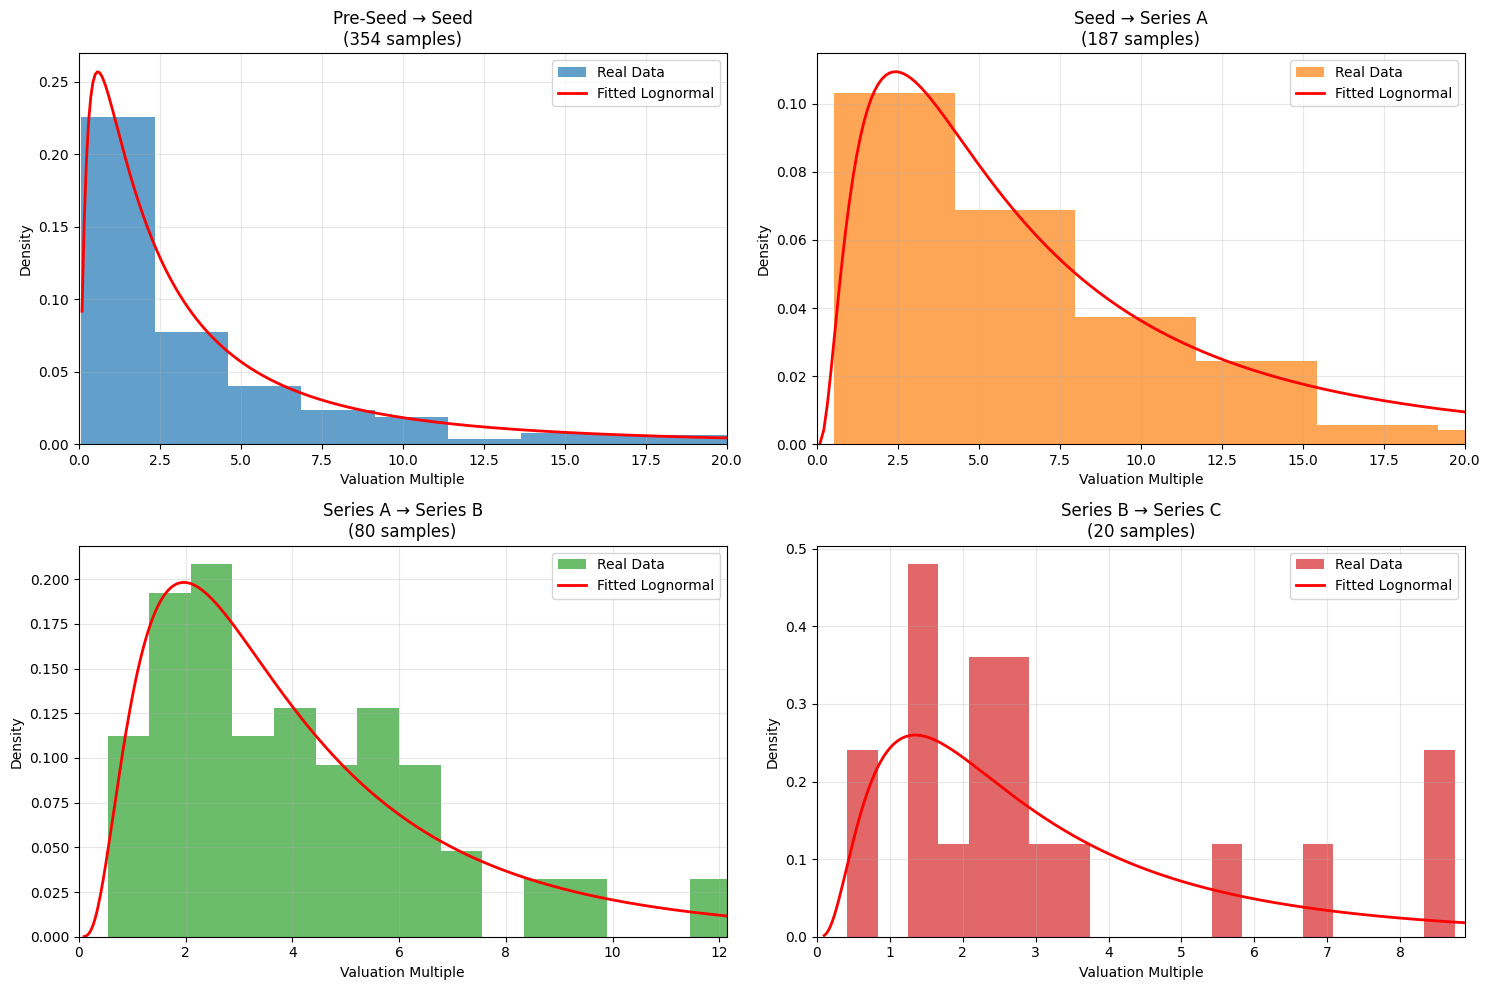

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from collections import defaultdict

# Load and process real data
def get_real_transitions():
   df = pd.read_csv('Valuation Rounds.csv', encoding='cp1252')
   
   stage_map = {'Pre-SEED': 'Pre-Seed', 'SEED': 'Seed', 'Series A': 'Series A', 'Series B': 'Series B', 'Series C': 'Series C'}
   
   clean = df[
       df['Name'].notna() & 
       df['Funding Stage'].isin(stage_map.keys()) &
       (df['Valuation (Estimated)'] > 0)
   ].copy()
   
   clean['stage'] = clean['Funding Stage'].map(stage_map)
   clean['company'] = clean['Name'].str.strip()
   
   companies = defaultdict(list)
   for _, row in clean.iterrows():
       companies[row['company']].append({'stage': row['stage'], 'val': row['Valuation (Estimated)']})
   
   stage_order = {'Pre-Seed': 0, 'Seed': 1, 'Series A': 2, 'Series B': 3, 'Series C': 4}
   transitions = []
   
   for company, rounds in companies.items():
       if len(rounds) < 2: continue
       
       unique = {}
       for r in rounds:
           if r['stage'] not in unique or unique[r['stage']]['val'] < r['val']:
               unique[r['stage']] = r
       
       sorted_rounds = sorted(unique.values(), key=lambda x: stage_order[x['stage']])
       
       for i in range(len(sorted_rounds) - 1):
           curr, next_r = sorted_rounds[i], sorted_rounds[i + 1]
           trans = f"{curr['stage']} → {next_r['stage']}"
           if trans in ['Pre-Seed → Seed', 'Seed → Series A', 'Series A → Series B', 'Series B → Series C']:
               transitions.append({
                   'transition': trans,
                   'multiple': next_r['val'] / curr['val']
               })
   
   return transitions

# Fit distribution to real data
def fit_distribution(data, dist_type='lognormal'):
   data = np.array(data)
   data = data[data > 0]  # Remove any zero or negative values
   
   if dist_type == 'lognormal':
       # Fit lognormal distribution
       log_data = np.log(data)
       mu_log = np.mean(log_data)
       sigma_log = np.std(log_data)
       
       # Calculate goodness of fit
       ks_stat, ks_p = stats.kstest(log_data, lambda x: stats.norm.cdf(x, mu_log, sigma_log))
       
       return {
           'type': 'lognormal',
           'mu_log': mu_log,
           'sigma_log': sigma_log,
           'median': np.exp(mu_log),
           'ks_stat': ks_stat,
           'ks_p': ks_p
       }
   
   elif dist_type == 'normal':
       # Fit normal distribution
       mu = np.mean(data)
       sigma = np.std(data)
       
       ks_stat, ks_p = stats.kstest(data, lambda x: stats.norm.cdf(x, mu, sigma))
       
       return {
           'type': 'normal',
           'mu': mu,
           'sigma': sigma,
           'ks_stat': ks_stat,
           'ks_p': ks_p
       }

# Analyze each transition
def analyze_transitions():
   transitions = get_real_transitions()
   
   transition_types = ['Pre-Seed → Seed', 'Seed → Series A', 'Series A → Series B', 'Series B → Series C']
   results = {}
   
   print("DISTRIBUTION FITTING RESULTS:")
   print("=" * 80)
   
   for trans_type in transition_types:
       data = [t['multiple'] for t in transitions if t['transition'] == trans_type]
       if len(data) < 10:
           print(f"\n{trans_type}: Insufficient data ({len(data)} samples)")
           continue
       
       data = np.array(data)
       
       # Fit both distributions
       lognorm_fit = fit_distribution(data, 'lognormal')
       normal_fit = fit_distribution(data, 'normal')
       
       # Choose best fit (higher p-value is better)
       best_fit = lognorm_fit if lognorm_fit['ks_p'] > normal_fit['ks_p'] else normal_fit
       
       results[trans_type] = {
           'data': data,
           'lognormal': lognorm_fit,
           'normal': normal_fit,
           'best_fit': best_fit
       }
       
       print(f"\n{trans_type} ({len(data)} samples):")
       print(f"  Real data - Mean: {np.mean(data):.2f}x, Median: {np.median(data):.2f}x")
       print(f"  Lognormal fit - μ_log: {lognorm_fit['mu_log']:.3f}, σ_log: {lognorm_fit['sigma_log']:.3f}, p-value: {lognorm_fit['ks_p']:.4f}")
       print(f"  Normal fit - μ: {normal_fit['mu']:.2f}, σ: {normal_fit['sigma']:.2f}, p-value: {normal_fit['ks_p']:.4f}")
       print(f"  Best fit: {best_fit['type'].upper()}")
   
   return results

# Create fitted simulation parameters
def create_fitted_parameters(results):
   print("\nFITTED SIMULATION PARAMETERS:")
   print("=" * 50)
   
   fitted_params = {}
   
   for trans_type, result in results.items():
       best = result['best_fit']
       
       if best['type'] == 'lognormal':
           fitted_params[trans_type] = {
               'type': 'lognormal',
               'mu_log': best['mu_log'],
               'sigma_log': best['sigma_log'],
               'median': best['median']
           }
           print(f"{trans_type}:")
           print(f"  Type: Lognormal")
           print(f"  median_valuation_multiple: {best['median']:.2f}x")
           print(f"  sigma_log: {best['sigma_log']:.3f}")
       else:
           fitted_params[trans_type] = {
               'type': 'normal',
               'mu': best['mu'],
               'sigma': best['sigma']
           }
           print(f"{trans_type}:")
           print(f"  Type: Normal")
           print(f"  mean_multiple: {best['mu']:.2f}x")
           print(f"  sigma: {best['sigma']:.3f}")
   
   return fitted_params

# Simulate using fitted parameters
def simulate_fitted(fitted_params, n_sims=100000):
   sim_results = []
   
   for trans_type, params in fitted_params.items():
       if params['type'] == 'lognormal':
           multiples = np.random.lognormal(params['mu_log'], params['sigma_log'], n_sims)
       else:
           multiples = np.random.normal(params['mu'], params['sigma'], n_sims)
           multiples = np.maximum(multiples, 0.01)  # Prevent negative multiples
       
       sim_results.append({
           'transition': trans_type,
           'source': 'Fitted Simulation',
           'sample_size': n_sims,
           'down_round': (multiples < 1).mean() * 100,
           'below_2x': (multiples < 2).mean() * 100,
           'below_3x': (multiples < 3).mean() * 100,
           'median': np.median(multiples),
           'mean': np.mean(multiples),
           'std': np.std(multiples)
       })
   
   return sim_results

# Visualize distributions
def plot_distributions(results):
   n_transitions = len(results)
   fig, axes = plt.subplots(2, 2, figsize=(15, 10))
   axes = axes.flatten()
   
   colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
   
   for i, (trans_type, result) in enumerate(results.items()):
       if i >= 4: break
       
       ax = axes[i]
       data = result['data']
       
       # Plot histogram of real data
       ax.hist(data, bins=30, alpha=0.7, density=True, color=colors[i], label='Real Data')
       
       # Plot fitted distribution
       x = np.linspace(0.1, max(data), 1000)
       best_fit = result['best_fit']
       
       if best_fit['type'] == 'lognormal':
           fitted_y = stats.lognorm.pdf(x, s=best_fit['sigma_log'], scale=np.exp(best_fit['mu_log']))
       else:
           fitted_y = stats.norm.pdf(x, best_fit['mu'], best_fit['sigma'])
       
       ax.plot(x, fitted_y, 'r-', linewidth=2, label=f'Fitted {best_fit["type"].title()}')
       
       ax.set_xlabel('Valuation Multiple')
       ax.set_ylabel('Density')
       ax.set_title(f'{trans_type}\n({len(data)} samples)')
       ax.legend()
       ax.grid(True, alpha=0.3)
       
       # Set reasonable x-axis limits
       ax.set_xlim(0, min(20, np.percentile(data, 95)))
   
   plt.tight_layout()
   plt.show()

# Run complete analysis
print("🔍 Analyzing valuation multiple distributions...")
results = analyze_transitions()

if results:
   fitted_params = create_fitted_parameters(results)
   
   # Save fitted parameters
   fitted_df = pd.DataFrame([
       {
           'transition': trans,
           'distribution_type': params['type'],
           'param1': params.get('mu_log', params.get('mu', 0)),
           'param2': params.get('sigma_log', params.get('sigma', 0)),
           'median_multiple': params.get('median', params.get('mu', 0))
       }
       for trans, params in fitted_params.items()
   ])
   fitted_df.to_csv('fitted_distribution_parameters.csv', index=False)
   print("\n💾 Saved fitted parameters to 'fitted_distribution_parameters.csv'")
   
   # Compare fitted simulation to real data
   fitted_sim_results = simulate_fitted(fitted_params)
   
   print("\nCOMPARISON: REAL DATA vs FITTED SIMULATION:")
   print("=" * 80)
   
   for result in fitted_sim_results:
       trans = result['transition']
       if trans in results:
           real_data = results[trans]['data']
           print(f"\n{trans}:")
           print(f"  Real Data     | Down:{(real_data < 1).mean()*100:5.1f}% | <2x:{(real_data < 2).mean()*100:5.1f}% | <3x:{(real_data < 3).mean()*100:5.1f}% | Med:{np.median(real_data):5.2f}x | Mean:{np.mean(real_data):5.2f}x")
           print(f"  Fitted Sim    | Down:{result['down_round']:5.1f}% | <2x:{result['below_2x']:5.1f}% | <3x:{result['below_3x']:5.1f}% | Med:{result['median']:5.2f}x | Mean:{result['mean']:5.2f}x")
   
   # Create visualizations
   plot_distributions(results)
else:
   print("❌ No sufficient data found for analysis")

🔍 Analyzing valuation distributions by stage...
VALUATION DISTRIBUTION FITTING RESULTS:

Pre-Seed (1596 samples):
  Real data - Mean: $3,373,068, Median: $1,550,000
  Lognormal fit - μ_log: 14.132, σ_log: 1.370, p-value: 0.0000
  Normal fit - μ: $3,373,068, σ: $7,068,103, p-value: 0.0000
  Best fit: LOGNORMAL
  Lognormal fit: ❌ POOR FIT
  Normal fit: ❌ POOR FIT

Seed (1738 samples):
  Real data - Mean: $7,668,085, Median: $3,900,000
  Lognormal fit - μ_log: 15.053, σ_log: 1.409, p-value: 0.0000
  Normal fit - μ: $7,668,085, σ: $13,564,822, p-value: 0.0000
  Best fit: LOGNORMAL
  Lognormal fit: ❌ POOR FIT
  Normal fit: ❌ POOR FIT

Series A (401 samples):
  Real data - Mean: $46,696,920, Median: $26,400,000
  Lognormal fit - μ_log: 17.046, σ_log: 1.128, p-value: 0.3491
  Normal fit - μ: $46,696,920, σ: $77,275,283, p-value: 0.0000
  Best fit: LOGNORMAL
  Lognormal fit: ✅ GOOD FIT
  Normal fit: ❌ POOR FIT

Series B (103 samples):
  Real data - Mean: $135,261,650, Median: $87,600,000
  Log

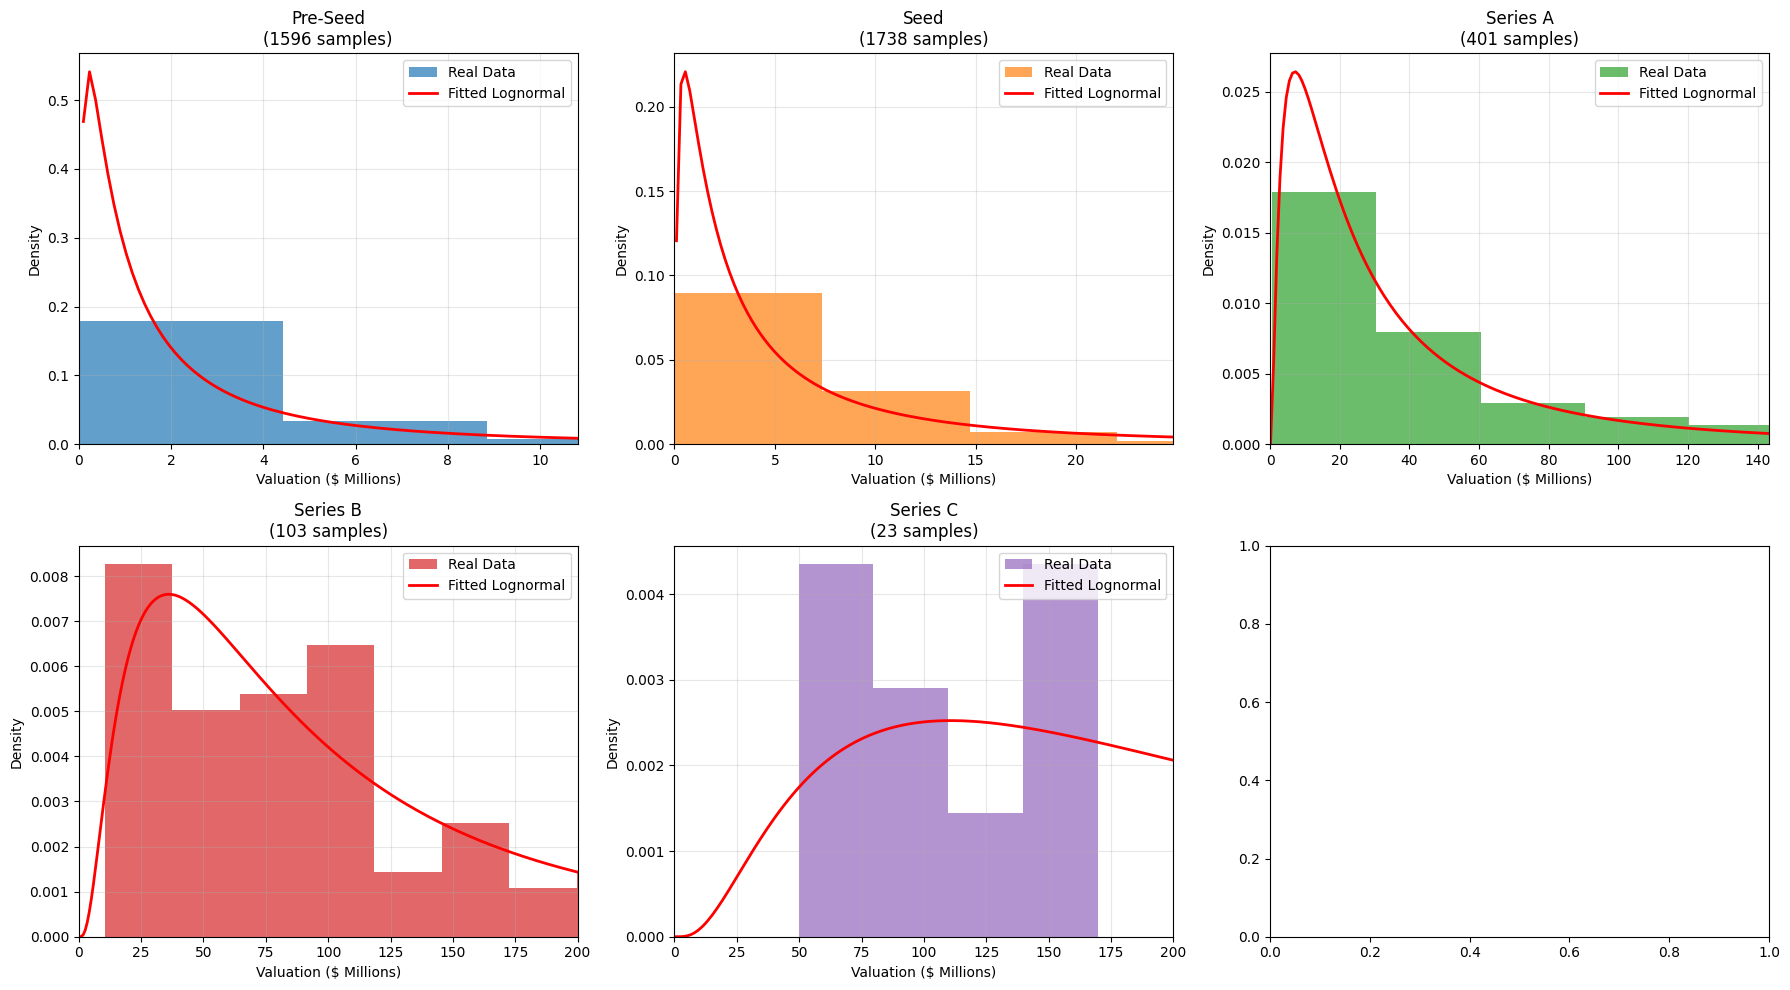


💾 Saved real valuation data to 'real_valuations_by_stage.csv'


In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict

# Load and process real data for valuations
def get_real_valuations():
   df = pd.read_csv('Valuation Rounds.csv', encoding='cp1252')
   
   stage_map = {'Pre-SEED': 'Pre-Seed', 'SEED': 'Seed', 'Series A': 'Series A', 'Series B': 'Series B', 'Series C': 'Series C'}
   
   clean = df[
       df['Name'].notna() & 
       df['Funding Stage'].isin(stage_map.keys()) &
       (df['Valuation (Estimated)'] > 0)
   ].copy()
   
   clean['stage'] = clean['Funding Stage'].map(stage_map)
   clean['company'] = clean['Name'].str.strip()
   
   valuations = []
   
   for _, row in clean.iterrows():
       valuations.append({
           'stage': row['stage'],
           'valuation': row['Valuation (Estimated)']
       })
   
   return valuations

# Fit distribution to real data
def fit_distribution(data, dist_type='lognormal'):
   data = np.array(data)
   data = data[data > 0]  # Remove any zero or negative values
   
   if dist_type == 'lognormal':
       # Fit lognormal distribution
       log_data = np.log(data)
       mu_log = np.mean(log_data)
       sigma_log = np.std(log_data)
       
       # Calculate goodness of fit
       ks_stat, ks_p = stats.kstest(log_data, lambda x: stats.norm.cdf(x, mu_log, sigma_log))
       
       return {
           'type': 'lognormal',
           'mu_log': mu_log,
           'sigma_log': sigma_log,
           'median': np.exp(mu_log),
           'ks_stat': ks_stat,
           'ks_p': ks_p
       }
   
   elif dist_type == 'normal':
       # Fit normal distribution
       mu = np.mean(data)
       sigma = np.std(data)
       
       ks_stat, ks_p = stats.kstest(data, lambda x: stats.norm.cdf(x, mu, sigma))
       
       return {
           'type': 'normal',
           'mu': mu,
           'sigma': sigma,
           'ks_stat': ks_stat,
           'ks_p': ks_p
       }

# Analyze each stage valuation
def analyze_valuations():
   valuations = get_real_valuations()
   
   stages = ['Pre-Seed', 'Seed', 'Series A', 'Series B', 'Series C']
   results = {}
   
   print("VALUATION DISTRIBUTION FITTING RESULTS:")
   print("=" * 80)
   
   for stage in stages:
       data = [v['valuation'] for v in valuations if v['stage'] == stage]
       if len(data) < 10:
           print(f"\n{stage}: Insufficient data ({len(data)} samples)")
           continue
       
       data = np.array(data)
       
       # Fit both distributions
       lognorm_fit = fit_distribution(data, 'lognormal')
       normal_fit = fit_distribution(data, 'normal')
       
       # Choose best fit (higher p-value is better)
       best_fit = lognorm_fit if lognorm_fit['ks_p'] > normal_fit['ks_p'] else normal_fit
       
       results[stage] = {
           'data': data,
           'lognormal': lognorm_fit,
           'normal': normal_fit,
           'best_fit': best_fit
       }
       
       print(f"\n{stage} ({len(data)} samples):")
       print(f"  Real data - Mean: ${np.mean(data):,.0f}, Median: ${np.median(data):,.0f}")
       print(f"  Lognormal fit - μ_log: {lognorm_fit['mu_log']:.3f}, σ_log: {lognorm_fit['sigma_log']:.3f}, p-value: {lognorm_fit['ks_p']:.4f}")
       print(f"  Normal fit - μ: ${normal_fit['mu']:,.0f}, σ: ${normal_fit['sigma']:,.0f}, p-value: {normal_fit['ks_p']:.4f}")
       print(f"  Best fit: {best_fit['type'].upper()}")
       
       # Add fit quality assessment
       lognorm_p = lognorm_fit['ks_p']
       normal_p = normal_fit['ks_p']
       print(f"  Lognormal fit: {'✅ GOOD FIT' if lognorm_p > 0.05 else '❌ POOR FIT'}")
       print(f"  Normal fit: {'✅ GOOD FIT' if normal_p > 0.05 else '❌ POOR FIT'}")
   
   return results

# Create fitted simulation parameters
def create_fitted_parameters(results):
   print("\nFITTED VALUATION SIMULATION PARAMETERS:")
   print("=" * 50)
   
   fitted_params = {}
   
   for stage, result in results.items():
       best = result['best_fit']
       
       if best['type'] == 'lognormal':
           fitted_params[stage] = {
               'type': 'lognormal',
               'mu_log': best['mu_log'],
               'sigma_log': best['sigma_log'],
               'median_valuation': best['median']
           }
           print(f"{stage}:")
           print(f"  Type: Lognormal")
           print(f"  median_valuation: ${best['median']:,.0f}")
           print(f"  sigma_log: {best['sigma_log']:.3f}")
       else:
           fitted_params[stage] = {
               'type': 'normal',
               'mean_valuation': best['mu'],
               'sigma': best['sigma']
           }
           print(f"{stage}:")
           print(f"  Type: Normal")
           print(f"  mean_valuation: ${best['mu']:,.0f}")
           print(f"  sigma: ${best['sigma']:,.0f}")
   
   return fitted_params

# Simulate using fitted parameters
def simulate_fitted_valuations(fitted_params, n_sims=100000):
   sim_results = []
   
   for stage, params in fitted_params.items():
       if params['type'] == 'lognormal':
           valuations = np.random.lognormal(params['mu_log'], params['sigma_log'], n_sims)
       else:
           valuations = np.random.normal(params['mean_valuation'], params['sigma'], n_sims)
           valuations = np.maximum(valuations, 100000)  # Minimum $100k valuation
       
       sim_results.append({
           'stage': stage,
           'source': 'Fitted Simulation',
           'sample_size': n_sims,
           'mean_valuation': np.mean(valuations),
           'median_valuation': np.median(valuations),
           'p10_valuation': np.percentile(valuations, 10),
           'p90_valuation': np.percentile(valuations, 90),
           'std_valuation': np.std(valuations)
       })
   
   return sim_results

# Visualize distributions
def plot_valuation_distributions(results):
   n_stages = len(results)
   fig, axes = plt.subplots(2, 3, figsize=(18, 10))
   axes = axes.flatten()
   
   colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
   
   for i, (stage, result) in enumerate(results.items()):
       if i >= 5: break
       
       ax = axes[i]
       data = result['data'] / 1e6  # Convert to millions for readability
       
       # Plot histogram of real data
       ax.hist(data, bins=30, alpha=0.7, density=True, color=colors[i], label='Real Data')
       
       # Plot fitted distribution
       x = np.linspace(0.1, max(data), 1000)
       best_fit = result['best_fit']
       
       if best_fit['type'] == 'lognormal':
           # Adjust for millions
           fitted_y = stats.lognorm.pdf(x * 1e6, s=best_fit['sigma_log'], scale=np.exp(best_fit['mu_log'])) * 1e6
       else:
           # Adjust for millions
           fitted_y = stats.norm.pdf(x * 1e6, best_fit['mu'], best_fit['sigma']) * 1e6
       
       ax.plot(x, fitted_y, 'r-', linewidth=2, label=f'Fitted {best_fit["type"].title()}')
       
       ax.set_xlabel('Valuation ($ Millions)')
       ax.set_ylabel('Density')
       ax.set_title(f'{stage}\n({len(result["data"])} samples)')
       ax.legend()
       ax.grid(True, alpha=0.3)
       
       # Set reasonable x-axis limits
       ax.set_xlim(0, min(200, np.percentile(data, 95)))
   
   plt.tight_layout()
   plt.show()

# Run complete analysis
print("🔍 Analyzing valuation distributions by stage...")
results = analyze_valuations()

if results:
   fitted_params = create_fitted_parameters(results)
   
   # Save fitted parameters
   fitted_df = pd.DataFrame([
       {
           'stage': stage,
           'distribution_type': params['type'],
           'param1': params.get('mu_log', params.get('mean_valuation', 0)),
           'param2': params.get('sigma_log', params.get('sigma', 0)),
           'median_valuation': params.get('median_valuation', params.get('mean_valuation', 0))
       }
       for stage, params in fitted_params.items()
   ])
   fitted_df.to_csv('fitted_valuation_parameters.csv', index=False)
   print("\n💾 Saved fitted parameters to 'fitted_valuation_parameters.csv'")
   
   # Compare fitted simulation to real data
   fitted_sim_results = simulate_fitted_valuations(fitted_params)
   
   print("\nCOMPARISON: REAL DATA vs FITTED SIMULATION:")
   print("=" * 90)
   
   for result in fitted_sim_results:
       stage = result['stage']
       if stage in results:
           real_data = results[stage]['data']
           print(f"\n{stage}:")
           print(f"  Real Data     | Mean:${np.mean(real_data):8,.0f} | Med:${np.median(real_data):8,.0f} | P10:${np.percentile(real_data, 10):8,.0f} | P90:${np.percentile(real_data, 90):8,.0f}")
           print(f"  Fitted Sim    | Mean:${result['mean_valuation']:8,.0f} | Med:${result['median_valuation']:8,.0f} | P10:${result['p10_valuation']:8,.0f} | P90:${result['p90_valuation']:8,.0f}")
   
   # Create visualizations
   plot_valuation_distributions(results)
   
   # Save real valuation data for reference
   all_valuations = []
   for stage, result in results.items():
       for val in result['data']:
           all_valuations.append({'stage': stage, 'valuation': val})
   
   pd.DataFrame(all_valuations).to_csv('real_valuations_by_stage.csv', index=False)
   print("\n💾 Saved real valuation data to 'real_valuations_by_stage.csv'")
   
else:
   print("❌ No sufficient data found for analysis")

🔍 Analyzing valuation distributions by stage (Post-2020)...
📅 Filtered to 2,080 rounds after 01/01/2020 (from 5,676 total)

VALUATION DISTRIBUTION FITTING RESULTS (POST-2020):

Pre-Seed (858 samples):
  Real data - Mean: $5,395,772, Median: $3,650,000
  Lognormal fit - μ_log: 14.869, σ_log: 1.158, p-value: 0.0000
  Normal fit - μ: $5,395,772, σ: $9,058,802, p-value: 0.0000
  Best fit: LOGNORMAL
  Lognormal fit: ❌ POOR FIT
  Normal fit: ❌ POOR FIT

Seed (944 samples):
  Real data - Mean: $11,500,446, Median: $9,250,000
  Lognormal fit - μ_log: 15.707, σ_log: 1.149, p-value: 0.0000
  Normal fit - μ: $11,500,446, σ: $17,021,596, p-value: 0.0000
  Best fit: LOGNORMAL
  Lognormal fit: ❌ POOR FIT
  Normal fit: ❌ POOR FIT

Series A (210 samples):
  Real data - Mean: $69,165,000, Median: $45,500,000
  Lognormal fit - μ_log: 17.649, σ_log: 0.858, p-value: 0.3895
  Normal fit - μ: $69,165,000, σ: $96,202,810, p-value: 0.0000
  Best fit: LOGNORMAL
  Lognormal fit: ✅ GOOD FIT
  Normal fit: ❌ POOR 

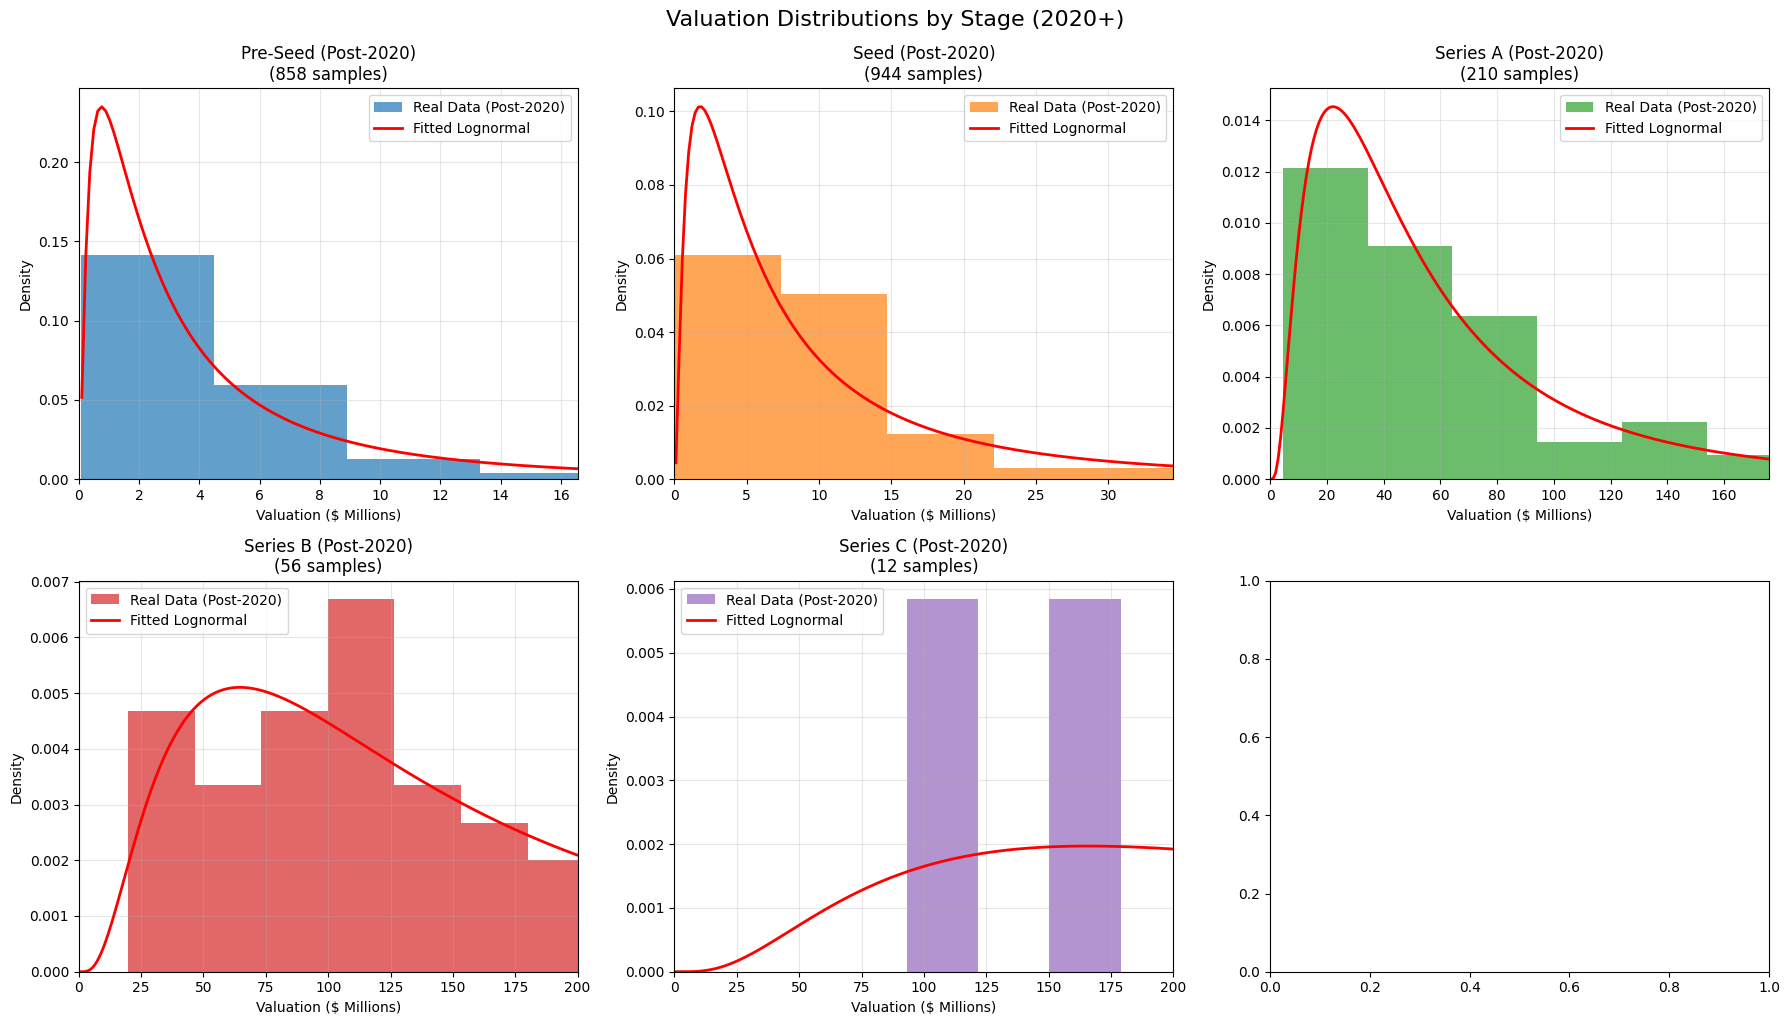


💾 Saved real valuation data to 'real_valuations_by_stage_post2020.csv'


In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict

# Load and process real data for valuations (filtered for 2020+)
def get_real_valuations_post2020():
   df = pd.read_csv('Valuation Rounds.csv', encoding='cp1252')
   
   # Convert Date Funded to datetime
   df['Date Funded'] = pd.to_datetime(df['Date Funded'], errors='coerce')
   
   # Filter for dates after 01/01/2020
   df_filtered = df[df['Date Funded'] >= '2020-01-01'].copy()
   
   stage_map = {'Pre-SEED': 'Pre-Seed', 'SEED': 'Seed', 'Series A': 'Series A', 'Series B': 'Series B', 'Series C': 'Series C'}
   
   clean = df_filtered[
       df_filtered['Name'].notna() & 
       df_filtered['Funding Stage'].isin(stage_map.keys()) &
       (df_filtered['Valuation (Estimated)'] > 0)
   ].copy()
   
   clean['stage'] = clean['Funding Stage'].map(stage_map)
   clean['company'] = clean['Name'].str.strip()
   
   print(f"📅 Filtered to {len(clean):,} rounds after 01/01/2020 (from {len(df):,} total)")
   
   valuations = []
   
   for _, row in clean.iterrows():
       valuations.append({
           'stage': row['stage'],
           'valuation': row['Valuation (Estimated)'],
           'date': row['Date Funded']
       })
   
   return valuations

# Fit distribution to real data
def fit_distribution(data, dist_type='lognormal'):
   data = np.array(data)
   data = data[data > 0]  # Remove any zero or negative values
   
   if dist_type == 'lognormal':
       # Fit lognormal distribution
       log_data = np.log(data)
       mu_log = np.mean(log_data)
       sigma_log = np.std(log_data)
       
       # Calculate goodness of fit
       ks_stat, ks_p = stats.kstest(log_data, lambda x: stats.norm.cdf(x, mu_log, sigma_log))
       
       return {
           'type': 'lognormal',
           'mu_log': mu_log,
           'sigma_log': sigma_log,
           'median': np.exp(mu_log),
           'ks_stat': ks_stat,
           'ks_p': ks_p
       }
   
   elif dist_type == 'normal':
       # Fit normal distribution
       mu = np.mean(data)
       sigma = np.std(data)
       
       ks_stat, ks_p = stats.kstest(data, lambda x: stats.norm.cdf(x, mu, sigma))
       
       return {
           'type': 'normal',
           'mu': mu,
           'sigma': sigma,
           'ks_stat': ks_stat,
           'ks_p': ks_p
       }

# Analyze each stage valuation (post-2020)
def analyze_valuations_post2020():
   valuations = get_real_valuations_post2020()
   
   stages = ['Pre-Seed', 'Seed', 'Series A', 'Series B', 'Series C']
   results = {}
   
   print("\nVALUATION DISTRIBUTION FITTING RESULTS (POST-2020):")
   print("=" * 80)
   
   for stage in stages:
       data = [v['valuation'] for v in valuations if v['stage'] == stage]
       if len(data) < 10:
           print(f"\n{stage}: Insufficient data ({len(data)} samples)")
           continue
       
       data = np.array(data)
       
       # Fit both distributions
       lognorm_fit = fit_distribution(data, 'lognormal')
       normal_fit = fit_distribution(data, 'normal')
       
       # Choose best fit (higher p-value is better)
       best_fit = lognorm_fit if lognorm_fit['ks_p'] > normal_fit['ks_p'] else normal_fit
       
       results[stage] = {
           'data': data,
           'lognormal': lognorm_fit,
           'normal': normal_fit,
           'best_fit': best_fit
       }
       
       print(f"\n{stage} ({len(data)} samples):")
       print(f"  Real data - Mean: ${np.mean(data):,.0f}, Median: ${np.median(data):,.0f}")
       print(f"  Lognormal fit - μ_log: {lognorm_fit['mu_log']:.3f}, σ_log: {lognorm_fit['sigma_log']:.3f}, p-value: {lognorm_fit['ks_p']:.4f}")
       print(f"  Normal fit - μ: ${normal_fit['mu']:,.0f}, σ: ${normal_fit['sigma']:,.0f}, p-value: {normal_fit['ks_p']:.4f}")
       print(f"  Best fit: {best_fit['type'].upper()}")
       
       # Add fit quality assessment
       lognorm_p = lognorm_fit['ks_p']
       normal_p = normal_fit['ks_p']
       print(f"  Lognormal fit: {'✅ GOOD FIT' if lognorm_p > 0.05 else '❌ POOR FIT'}")
       print(f"  Normal fit: {'✅ GOOD FIT' if normal_p > 0.05 else '❌ POOR FIT'}")
   
   return results

# Create fitted simulation parameters
def create_fitted_parameters_post2020(results):
   print("\nFITTED VALUATION SIMULATION PARAMETERS (POST-2020):")
   print("=" * 50)
   
   fitted_params = {}
   
   for stage, result in results.items():
       best = result['best_fit']
       
       if best['type'] == 'lognormal':
           fitted_params[stage] = {
               'type': 'lognormal',
               'mu_log': best['mu_log'],
               'sigma_log': best['sigma_log'],
               'median_valuation': best['median']
           }
           print(f"{stage}:")
           print(f"  Type: Lognormal")
           print(f"  median_valuation: ${best['median']:,.0f}")
           print(f"  sigma_log: {best['sigma_log']:.3f}")
       else:
           fitted_params[stage] = {
               'type': 'normal',
               'mean_valuation': best['mu'],
               'sigma': best['sigma']
           }
           print(f"{stage}:")
           print(f"  Type: Normal")
           print(f"  mean_valuation: ${best['mu']:,.0f}")
           print(f"  sigma: ${best['sigma']:,.0f}")
   
   return fitted_params

# Simulate using fitted parameters
def simulate_fitted_valuations_post2020(fitted_params, n_sims=100000):
   sim_results = []
   
   for stage, params in fitted_params.items():
       if params['type'] == 'lognormal':
           valuations = np.random.lognormal(params['mu_log'], params['sigma_log'], n_sims)
       else:
           valuations = np.random.normal(params['mean_valuation'], params['sigma'], n_sims)
           valuations = np.maximum(valuations, 100000)  # Minimum $100k valuation
       
       sim_results.append({
           'stage': stage,
           'source': 'Fitted Simulation (Post-2020)',
           'sample_size': n_sims,
           'mean_valuation': np.mean(valuations),
           'median_valuation': np.median(valuations),
           'p10_valuation': np.percentile(valuations, 10),
           'p90_valuation': np.percentile(valuations, 90),
           'std_valuation': np.std(valuations)
       })
   
   return sim_results

# Visualize distributions
def plot_valuation_distributions_post2020(results):
   n_stages = len(results)
   fig, axes = plt.subplots(2, 3, figsize=(18, 10))
   axes = axes.flatten()
   
   colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
   
   for i, (stage, result) in enumerate(results.items()):
       if i >= 5: break
       
       ax = axes[i]
       data = result['data'] / 1e6  # Convert to millions for readability
       
       # Plot histogram of real data
       ax.hist(data, bins=30, alpha=0.7, density=True, color=colors[i], label='Real Data (Post-2020)')
       
       # Plot fitted distribution
       x = np.linspace(0.1, max(data), 1000)
       best_fit = result['best_fit']
       
       if best_fit['type'] == 'lognormal':
           # Adjust for millions
           fitted_y = stats.lognorm.pdf(x * 1e6, s=best_fit['sigma_log'], scale=np.exp(best_fit['mu_log'])) * 1e6
       else:
           # Adjust for millions
           fitted_y = stats.norm.pdf(x * 1e6, best_fit['mu'], best_fit['sigma']) * 1e6
       
       ax.plot(x, fitted_y, 'r-', linewidth=2, label=f'Fitted {best_fit["type"].title()}')
       
       ax.set_xlabel('Valuation ($ Millions)')
       ax.set_ylabel('Density')
       ax.set_title(f'{stage} (Post-2020)\n({len(result["data"])} samples)')
       ax.legend()
       ax.grid(True, alpha=0.3)
       
       # Set reasonable x-axis limits
       ax.set_xlim(0, min(200, np.percentile(data, 95)))
   
   plt.tight_layout()
   plt.suptitle('Valuation Distributions by Stage (2020+)', y=1.02, fontsize=16)
   plt.show()

# Run complete analysis
print("🔍 Analyzing valuation distributions by stage (Post-2020)...")
results = analyze_valuations_post2020()

if results:
   fitted_params = create_fitted_parameters_post2020(results)
   
   # Save fitted parameters
   fitted_df = pd.DataFrame([
       {
           'stage': stage,
           'distribution_type': params['type'],
           'param1': params.get('mu_log', params.get('mean_valuation', 0)),
           'param2': params.get('sigma_log', params.get('sigma', 0)),
           'median_valuation': params.get('median_valuation', params.get('mean_valuation', 0)),
           'period': 'post_2020'
       }
       for stage, params in fitted_params.items()
   ])
   fitted_df.to_csv('fitted_valuation_parameters_post2020.csv', index=False)
   print("\n💾 Saved fitted parameters to 'fitted_valuation_parameters_post2020.csv'")
   
   # Compare fitted simulation to real data
   fitted_sim_results = simulate_fitted_valuations_post2020(fitted_params)
   
   print("\nCOMPARISON: REAL DATA vs FITTED SIMULATION (POST-2020):")
   print("=" * 90)
   
   for result in fitted_sim_results:
       stage = result['stage']
       if stage in results:
           real_data = results[stage]['data']
           print(f"\n{stage}:")
           print(f"  Real Data     | Mean:${np.mean(real_data):8,.0f} | Med:${np.median(real_data):8,.0f} | P10:${np.percentile(real_data, 10):8,.0f} | P90:${np.percentile(real_data, 90):8,.0f}")
           print(f"  Fitted Sim    | Mean:${result['mean_valuation']:8,.0f} | Med:${result['median_valuation']:8,.0f} | P10:${result['p10_valuation']:8,.0f} | P90:${result['p90_valuation']:8,.0f}")
   
   # Create visualizations
   plot_valuation_distributions_post2020(results)
   
   # Save real valuation data for reference
   all_valuations = []
   for stage, result in results.items():
       for val in result['data']:
           all_valuations.append({'stage': stage, 'valuation': val, 'period': 'post_2020'})
   
   pd.DataFrame(all_valuations).to_csv('real_valuations_by_stage_post2020.csv', index=False)
   print("\n💾 Saved real valuation data to 'real_valuations_by_stage_post2020.csv'")
   
else:
   print("❌ No sufficient data found for analysis")

In [11]:
import pandas as pd
import numpy as np
from collections import defaultdict

def analyze_survival_rates():
   # Load data
   df = pd.read_csv('Valuation Rounds.csv', encoding='cp1252')
   
   # Define stage mapping and order
   stage_map = {
       'Pre-SEED': 'Pre-Seed', 
       'SEED': 'Seed', 
       'Series A': 'Series A', 
       'Series B': 'Series B', 
       'Series C': 'Series C'
   }
   
   stage_order = {'Pre-Seed': 0, 'Seed': 1, 'Series A': 2, 'Series B': 3, 'Series C': 4}
   
   # Filter for relevant stages only
   clean = df[
       df['Name'].notna() & 
       df['Funding Stage'].isin(stage_map.keys())
   ].copy()
   
   clean['stage'] = clean['Funding Stage'].map(stage_map)
   clean['company'] = clean['Name'].str.strip()
   
   print(f"📊 Analyzing {len(clean):,} rounds from {clean['company'].nunique():,} companies")
   
   # Group by company and get their funding progression
   companies = defaultdict(set)  # Use set to avoid duplicate stages
   for _, row in clean.iterrows():
       companies[row['company']].add(row['stage'])
   
   # Convert sets to sorted lists based on stage order
   company_progressions = {}
   for company, stages in companies.items():
       sorted_stages = sorted(list(stages), key=lambda x: stage_order[x])
       company_progressions[company] = sorted_stages
   
   print(f"🏢 Found {len(company_progressions)} companies with funding data")
   
   # Calculate survival rates
   survival_data = []
   stages = ['Pre-Seed', 'Seed', 'Series A', 'Series B', 'Series C']
   
   print("\nSURVIVAL RATE ANALYSIS:")
   print("=" * 80)
   
   for i, current_stage in enumerate(stages[:-1]):  # Exclude last stage as it has no "next"
       # Find companies that have the current stage
       companies_with_current = [
           company for company, progression in company_progressions.items() 
           if current_stage in progression
       ]
       
       if len(companies_with_current) == 0:
           print(f"\n{current_stage}: No companies found")
           continue
       
       # For each possible next stage, calculate survival
       stage_results = {
           'current_stage': current_stage,
           'total_companies': len(companies_with_current)
       }
       
       print(f"\n{current_stage} ({len(companies_with_current)} companies):")
       
       # Check survival to each subsequent stage
       for j, next_stage in enumerate(stages[i+1:], i+1):
           companies_with_next = [
               company for company in companies_with_current
               if next_stage in company_progressions[company]
           ]
           
           survival_rate = len(companies_with_next) / len(companies_with_current) * 100
           stage_results[f'survival_to_{next_stage}'] = survival_rate
           stage_results[f'count_to_{next_stage}'] = len(companies_with_next)
           
           print(f"  → {next_stage}: {len(companies_with_next):3d}/{len(companies_with_current):3d} = {survival_rate:5.1f}%")
       
       # Calculate survival to ANY next round
       companies_with_any_next = [
           company for company in companies_with_current
           if any(stage in company_progressions[company] for stage in stages[i+1:])
       ]
       
       any_next_survival = len(companies_with_any_next) / len(companies_with_current) * 100
       stage_results['survival_to_any_next'] = any_next_survival
       stage_results['count_to_any_next'] = len(companies_with_any_next)
       
       print(f"  → ANY NEXT: {len(companies_with_any_next):3d}/{len(companies_with_current):3d} = {any_next_survival:5.1f}%")
       
       survival_data.append(stage_results)
   
   # Create detailed survival matrix
   print(f"\nSURVIVAL MATRIX:")
   print("=" * 80)
   print(f"{'From Stage':<12} {'Companies':<10} {'To Any':<8} {'To Seed':<8} {'To Ser A':<8} {'To Ser B':<8} {'To Ser C':<8}")
   print("-" * 80)
   
   for data in survival_data:
       current = data['current_stage']
       total = data['total_companies']
       any_next = data.get('survival_to_any_next', 0)
       
       to_seed = data.get('survival_to_Seed', 0) if 'survival_to_Seed' in data else '-'
       to_a = data.get('survival_to_Series A', 0) if 'survival_to_Series A' in data else '-'
       to_b = data.get('survival_to_Series B', 0) if 'survival_to_Series B' in data else '-'
       to_c = data.get('survival_to_Series C', 0) if 'survival_to_Series C' in data else '-'
       
       print(f"{current:<12} {total:<10} {any_next:>6.1f}% {to_seed:>6}% {to_a:>6}% {to_b:>6}% {to_c:>6}%")
   
   # Save detailed results
   survival_df = pd.DataFrame(survival_data)
   survival_df.to_csv('survival_rates_by_stage.csv', index=False)
   
   # Create summary for simulation parameters
   print(f"\nSIMULATION PARAMETERS (Survival to ANY next round):")
   print("=" * 50)
   
   sim_params = []
   for data in survival_data:
       current = data['current_stage']
       survival_rate = data.get('survival_to_any_next', 0) / 100  # Convert to probability
       failure_rate = 1 - survival_rate
       
       sim_params.append({
           'stage': current,
           'prob_to_next_stage': round(survival_rate, 3),
           'prob_to_fail': round(failure_rate, 3),
           'sample_size': data['total_companies']
       })
       
       print(f"{current}:")
       print(f"  prob_to_next_stage: {survival_rate:.3f}")
       print(f"  prob_to_fail: {failure_rate:.3f}")
       print(f"  (based on {data['total_companies']} companies)")
   
   # Save simulation parameters
   sim_df = pd.DataFrame(sim_params)
   sim_df.to_csv('survival_simulation_parameters.csv', index=False)
   
   print(f"\n💾 Saved detailed results to 'survival_rates_by_stage.csv'")
   print(f"💾 Saved simulation parameters to 'survival_simulation_parameters.csv'")
   
   # Additional analysis: Company journey patterns
   print(f"\nCOMPANY JOURNEY PATTERNS:")
   print("=" * 40)
   
   journey_patterns = defaultdict(int)
   for company, progression in company_progressions.items():
       pattern = " → ".join(progression)
       journey_patterns[pattern] += 1
   
   # Show top 10 most common patterns
   top_patterns = sorted(journey_patterns.items(), key=lambda x: x[1], reverse=True)[:10]
   
   for i, (pattern, count) in enumerate(top_patterns, 1):
       pct = count / len(company_progressions) * 100
       print(f"{i:2d}. {pattern:<25} ({count:3d} companies, {pct:4.1f}%)")
   
   # Save journey patterns
   patterns_df = pd.DataFrame([
       {'journey_pattern': pattern, 'company_count': count, 'percentage': count/len(company_progressions)*100}
       for pattern, count in journey_patterns.items()
   ]).sort_values('company_count', ascending=False)
   
   patterns_df.to_csv('company_journey_patterns.csv', index=False)
   print(f"\n💾 Saved journey patterns to 'company_journey_patterns.csv'")
   
   return survival_data, sim_params, patterns_df

# Run the analysis
print("🔍 Analyzing survival rates across funding stages...")
survival_results, simulation_params, journey_patterns = analyze_survival_rates()

🔍 Analyzing survival rates across funding stages...
📊 Analyzing 3,987 rounds from 3,078 companies
🏢 Found 3078 companies with funding data

SURVIVAL RATE ANALYSIS:

Pre-Seed (1580 companies):
  → Seed: 372/1580 =  23.5%
  → Series A:  49/1580 =   3.1%
  → Series B:   7/1580 =   0.4%
  → Series C:   0/1580 =   0.0%
  → ANY NEXT: 386/1580 =  24.4%

Seed (1677 companies):
  → Series A: 188/1677 =  11.2%
  → Series B:  56/1677 =   3.3%
  → Series C:  16/1677 =   1.0%
  → ANY NEXT: 195/1677 =  11.6%

Series A (379 companies):
  → Series B:  81/379 =  21.4%
  → Series C:  19/379 =   5.0%
  → ANY NEXT:  82/379 =  21.6%

Series B (102 companies):
  → Series C:  22/102 =  21.6%
  → ANY NEXT:  22/102 =  21.6%

SURVIVAL MATRIX:
From Stage   Companies  To Any   To Seed  To Ser A To Ser B To Ser C
--------------------------------------------------------------------------------
Pre-Seed     1580         24.4% 23.544303797468356% 3.10126582278481% 0.44303797468354433%    0.0%
Seed         1677       

MULTIPLE DISTRIBUTION ANALYSIS
Distribution: Lognormal
Median multiple: 6.02x
Sigma_log: 0.954
Mu_log: 1.795

KEY STATISTICS:
------------------------------
Mean    :   9.41x
Median  :   6.00x
Std Dev :  11.22x
P10     :   1.75x
P25     :   3.15x
P75     :  11.45x
P90     :  20.27x
P95     :  28.67x
Min     :   0.09x
Max     : 291.85x

PROBABILITY RANGES:
------------------------------
Down round (<1x):   3.0%
Below 2x       :  12.6%
Below 3x       :  23.4%
Below 5x       :  42.5%
Below 10x      :  70.4%
Above 10x      :  29.6%
Above 20x      :  10.2%


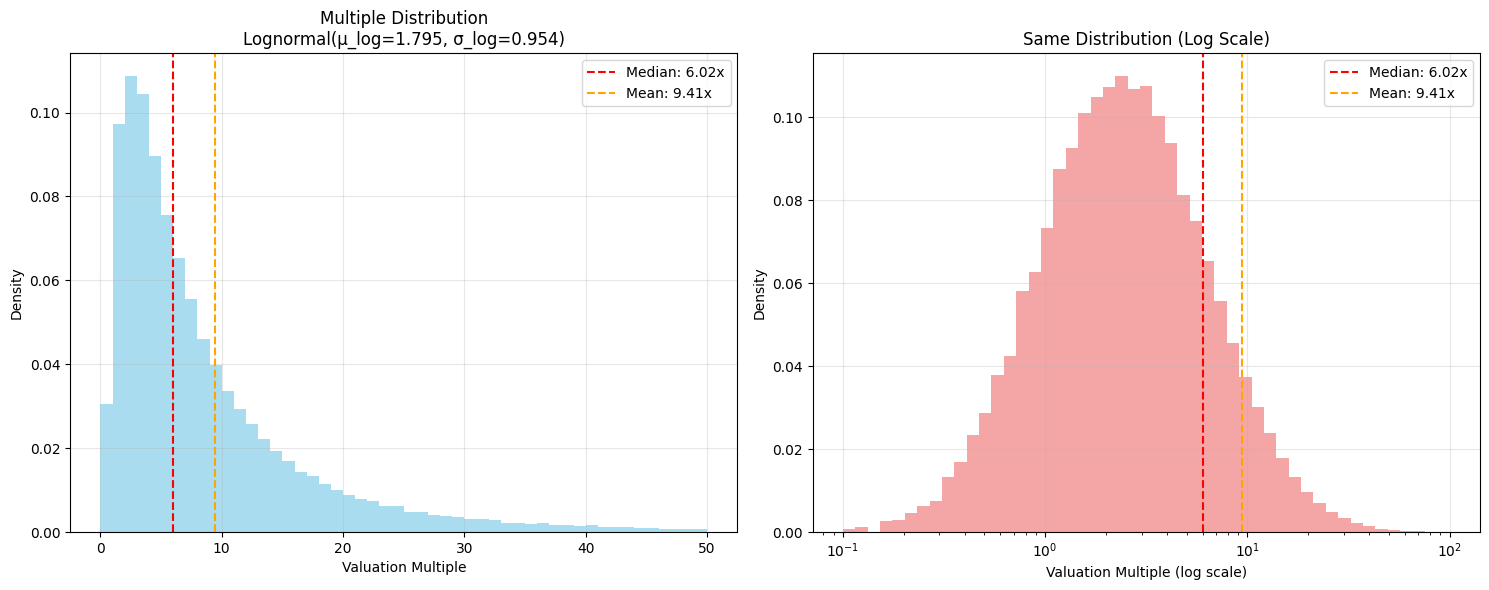

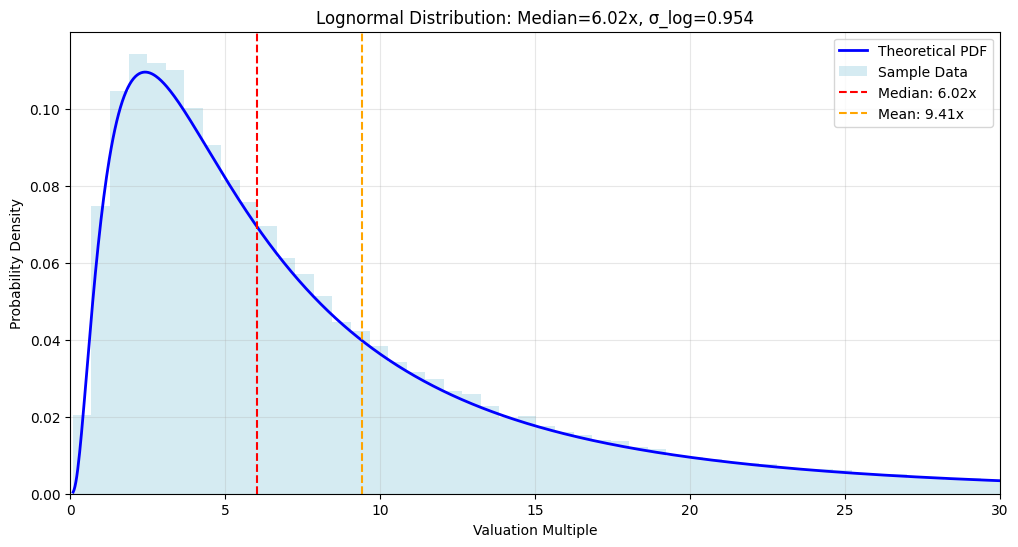


SUMMARY TABLE:
Metric  Value
Median  6.00x
  Mean  9.41x
   P10  1.75x
   P25  3.15x
   P75 11.45x
   P90 20.27x
   P95 28.67x

This distribution suggests:
• Typical multiple: ~6.0x (median)
• High variability: 0.95 sigma_log means wide spread
• 3.0% chance of down rounds
• 29.6% chance of 10x+ returns
• 10.2% chance of 20x+ returns


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Define the distribution parameters
median_multiple = 6.02
sigma_log = 0.954
mu_log = np.log(median_multiple)

print(f"MULTIPLE DISTRIBUTION ANALYSIS")
print("=" * 50)
print(f"Distribution: Lognormal")
print(f"Median multiple: {median_multiple:.2f}x")
print(f"Sigma_log: {sigma_log:.3f}")
print(f"Mu_log: {mu_log:.3f}")

# Generate sample data
n_samples = 100000
multiples = np.random.lognormal(mu_log, sigma_log, n_samples)

# Calculate key statistics
stats_dict = {
   'Mean': np.mean(multiples),
   'Median': np.median(multiples),
   'Std Dev': np.std(multiples),
   'P10': np.percentile(multiples, 10),
   'P25': np.percentile(multiples, 25),
   'P75': np.percentile(multiples, 75),
   'P90': np.percentile(multiples, 90),
   'P95': np.percentile(multiples, 95),
   'Min': np.min(multiples),
   'Max': np.max(multiples)
}

print(f"\nKEY STATISTICS:")
print("-" * 30)
for stat, value in stats_dict.items():
   print(f"{stat:<8}: {value:6.2f}x")

# Calculate probability ranges
prob_ranges = {
   'Down round (<1x)': (multiples < 1.0).mean() * 100,
   'Below 2x': (multiples < 2.0).mean() * 100,
   'Below 3x': (multiples < 3.0).mean() * 100,
   'Below 5x': (multiples < 5.0).mean() * 100,
   'Below 10x': (multiples < 10.0).mean() * 100,
   'Above 10x': (multiples > 10.0).mean() * 100,
   'Above 20x': (multiples > 20.0).mean() * 100
}

print(f"\nPROBABILITY RANGES:")
print("-" * 30)
for range_desc, prob in prob_ranges.items():
   print(f"{range_desc:<15}: {prob:5.1f}%")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
ax1.hist(multiples, bins=50, density=True, alpha=0.7, color='skyblue', 
        range=(0, min(50, np.percentile(multiples, 99))))
ax1.set_xlabel('Valuation Multiple')
ax1.set_ylabel('Density')
ax1.set_title(f'Multiple Distribution\nLognormal(μ_log={mu_log:.3f}, σ_log={sigma_log:.3f})')
ax1.grid(True, alpha=0.3)
ax1.axvline(median_multiple, color='red', linestyle='--', label=f'Median: {median_multiple:.2f}x')
ax1.axvline(np.mean(multiples), color='orange', linestyle='--', label=f'Mean: {np.mean(multiples):.2f}x')
ax1.legend()

# Log scale histogram for better view of distribution
ax2.hist(multiples, bins=np.logspace(np.log10(0.1), np.log10(100), 50), 
        density=True, alpha=0.7, color='lightcoral')
ax2.set_xscale('log')
ax2.set_xlabel('Valuation Multiple (log scale)')
ax2.set_ylabel('Density')
ax2.set_title('Same Distribution (Log Scale)')
ax2.grid(True, alpha=0.3)
ax2.axvline(median_multiple, color='red', linestyle='--', label=f'Median: {median_multiple:.2f}x')
ax2.axvline(np.mean(multiples), color='orange', linestyle='--', label=f'Mean: {np.mean(multiples):.2f}x')
ax2.legend()

plt.tight_layout()
plt.show()

# Show theoretical PDF curve
x = np.linspace(0.1, 30, 1000)
pdf_values = stats.lognorm.pdf(x, s=sigma_log, scale=median_multiple)

plt.figure(figsize=(12, 6))
plt.plot(x, pdf_values, 'b-', linewidth=2, label='Theoretical PDF')
plt.hist(multiples[multiples <= 30], bins=50, density=True, alpha=0.5, color='lightblue', label='Sample Data')
plt.axvline(median_multiple, color='red', linestyle='--', label=f'Median: {median_multiple:.2f}x')
plt.axvline(np.mean(multiples), color='orange', linestyle='--', label=f'Mean: {np.mean(multiples):.2f}x')
plt.xlabel('Valuation Multiple')
plt.ylabel('Probability Density')
plt.title(f'Lognormal Distribution: Median={median_multiple:.2f}x, σ_log={sigma_log:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 30)
plt.show()

# Summary table for easy reference
summary_data = {
   'Metric': ['Median', 'Mean', 'P10', 'P25', 'P75', 'P90', 'P95'],
   'Value': [
       f"{np.median(multiples):.2f}x",
       f"{np.mean(multiples):.2f}x", 
       f"{np.percentile(multiples, 10):.2f}x",
       f"{np.percentile(multiples, 25):.2f}x",
       f"{np.percentile(multiples, 75):.2f}x",
       f"{np.percentile(multiples, 90):.2f}x",
       f"{np.percentile(multiples, 95):.2f}x"
   ]
}

import pandas as pd
summary_df = pd.DataFrame(summary_data)
print(f"\nSUMMARY TABLE:")
print(summary_df.to_string(index=False))

print(f"\nThis distribution suggests:")
print(f"• Typical multiple: ~{median_multiple:.1f}x (median)")
print(f"• High variability: {sigma_log:.2f} sigma_log means wide spread")
print(f"• {prob_ranges['Down round (<1x)']:.1f}% chance of down rounds")
print(f"• {prob_ranges['Above 10x']:.1f}% chance of 10x+ returns")
print(f"• {prob_ranges['Above 20x']:.1f}% chance of 20x+ returns")